# 数据清理整合及基础数据分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import scipy
import scipy.stats

In [2]:
#1.0 数据导入操作：读取保单、赔款数据集
df_pol = pd.read_csv('Data/policy_sample.csv',index_col=False)
df_clm = pd.read_csv('Data/claim_sample.csv',index_col=False)
df_pol.drop('Unnamed: 0',axis=1,inplace=True)
df_clm.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
df_pol_clm = pd.merge(df_pol,df_clm,on=['pol_no'],how='left')
df_pol_clm.loc[df_pol_clm[df_pol_clm.ultloss.isnull()==True].index,'ultloss'] = 0

In [4]:
df_pol_clm.head()

,pol_no,usage_type_x,coverage_x,ncd_reason,pol_year_x,region_x,gender,insured_age,veh_age_c,veh_code,...,premium_ori,premium_new,renew_year,clmno,pol_year_y,region_y,usage_type_y,coverage_y,ultloss,acc_year
0,2011OC00001,private,PD,0_F,2011,region_3,F,26.0,VAGEC<0.9,VTVZTNCX6669,...,5640.0324,5543.598552,0,CLM2011100000002,2011.0,region_3,private,PD,4509.826774,2011.0
1,2011OC00002,private,PD,0_E,2011,region_3,M,39.0,VAGEC<1.9,VMIUMCCW6668,...,9654.3144,10738.602922,0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,2011OA00003,private,PD,1,2011,region_1,M,39.0,VAGEC<4.9,VMLVYBCW6660,...,6597.7800,7777.834560,2,CLM2011100000008,2011.0,region_1,private,PD,2326.435493,2011.0
3,2011ON00004,private,PD,0_F,2011,region_14,M,35.0,VAGEC<0.9,VVNVRGCX6698,...,19882.4880,19692.205320,0,CLM2012100000009,2011.0,region_14,private,PD,20891.460269,2012.0
4,2011OA00005,private,PD,0_D,2011,region_1,M,45.0,VAGEC<4.9,VXZLEBCV6669,...,3321.3288,2859.032526,3,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


In [5]:
#1.1 求出同一保单下的总赔付金额和赔付次数
df_pol_clm_grp_pol = df_pol_clm.groupby('pol_no',as_index=False)
df_pol_clm_grp_pol2 = df_pol_clm_grp_pol.agg({'clmno':'count','ultloss':'sum'})

In [6]:
df_pol_clm_grp_pol2.head()

,pol_no,clmno,ultloss
0,2011OA00003,1,2326.435493
1,2011OA00005,0,0.000000
2,2011OA00006,3,2593.606966
3,2011OA00009,2,1518.434898
4,2011OA00012,1,2501.326951


In [7]:
#1.2 得出最终包含保单信息和赔付信息的数据库
df_all = pd.merge(df_pol,df_pol_clm_grp_pol2,on='pol_no',how='inner')

In [8]:
#2.1 年龄离散化
w = [0,18,20,25,30,35,40,45,50,55,60,75,100]
df_all.loc[:,'AgeC'] = pd.cut(df_all.insured_age,w,right=False)

#2.2 座位离散化
w = [0,6,11,20]
df_all.loc[:,'SeatC'] = pd.cut(df_all.veh_seat,w,right=False)

#2.3 车价离散化
w = [0,100000,150000,200000,250000,300000,400000,500000,999999,1500000]
df_all.loc[:,'PRC'] = pd.cut(df_all.veh_price,w,right=False)

In [9]:
df_all['AgeC'] = df_all.AgeC.astype(str)
df_all['SeatC'] = df_all.SeatC.astype(str)
df_all['PRC'] = df_all.PRC.astype(str)

In [10]:
df_all.dtypes

pol_no          object
usage_type      object
coverage        object
ncd_reason      object
pol_year         int64
region          object
gender          object
insured_age    float64
veh_age_c       object
veh_code        object
import_ind      object
veh_brand       object
veh_class       object
veh_series      object
veh_price        int64
veh_seat         int64
wr_year          int64
nodc_ind        object
premium_ori    float64
premium_new    float64
renew_year       int64
clmno            int64
ultloss        float64
AgeC            object
SeatC           object
PRC             object
dtype: object

In [11]:
df_all.head()

,pol_no,usage_type,coverage,ncd_reason,pol_year,region,gender,insured_age,veh_age_c,veh_code,...,wr_year,nodc_ind,premium_ori,premium_new,renew_year,clmno,ultloss,AgeC,SeatC,PRC
0,2011OC00001,private,PD,0_F,2011,region_3,F,26.0,VAGEC<0.9,VTVZTNCX6669,...,1,Y,5640.0324,5543.598552,0,1,4509.826774,"[25, 30)","[0, 6)","[200000, 250000)"
1,2011OC00002,private,PD,0_E,2011,region_3,M,39.0,VAGEC<1.9,VMIUMCCW6668,...,1,Y,9654.3144,10738.602922,0,0,0.000000,"[35, 40)","[0, 6)","[500000, 999999)"
2,2011OA00003,private,PD,1,2011,region_1,M,39.0,VAGEC<4.9,VMLVYBCW6660,...,1,Y,6597.7800,7777.834560,2,1,2326.435493,"[35, 40)","[0, 6)","[300000, 400000)"
3,2011ON00004,private,PD,0_F,2011,region_14,M,35.0,VAGEC<0.9,VVNVRGCX6698,...,1,Y,19882.4880,19692.205320,0,1,20891.460269,"[35, 40)","[0, 6)","[500000, 999999)"
4,2011OA00005,private,PD,0_D,2011,region_1,M,45.0,VAGEC<4.9,VXZLEBCV6669,...,1,Y,3321.3288,2859.032526,3,0,0.000000,"[45, 50)","[0, 6)","[150000, 200000)"


In [12]:
#3.1 考虑NCD分组下的保费和赔付信息
df_ncd_grp = df_all.groupby('ncd_reason',as_index=False).agg({'pol_no':'count','clmno':'sum','ultloss':'sum','premium_ori':'sum','premium_new':'sum'})
df_ncd_grp.loc[:,'LR_1'] = df_ncd_grp.ultloss / df_ncd_grp.premium_ori
df_ncd_grp.loc[:,'LR_2'] = df_ncd_grp.ultloss / df_ncd_grp.premium_new


In [13]:
df_ncd_grp

,ncd_reason,pol_no,clmno,ultloss,premium_ori,premium_new,LR_1,LR_2
0,0_A,1529,461,1.418496e+06,3.478247e+06,3.050197e+06,0.407819,0.465051
1,0_B,1604,504,1.626135e+06,3.775525e+06,3.313983e+06,0.430704,0.490689
2,0_C,685,269,8.544703e+05,1.562742e+06,1.375908e+06,0.546776,0.621023
3,0_D,4189,1664,5.416498e+06,1.097649e+07,9.861380e+06,0.493464,0.549264
4,0_E,10643,5221,1.851430e+07,3.178149e+07,3.087845e+07,0.582550,0.599586
5,0_F,14630,9832,3.253436e+07,5.042489e+07,5.175865e+07,0.645204,0.628578
6,0_G,2739,1997,7.939982e+06,9.044025e+06,9.246807e+06,0.877926,0.858673
7,1,8889,5132,1.668849e+07,2.908784e+07,2.982739e+07,0.573727,0.559502
8,2,3939,3110,9.665934e+06,1.278597e+07,1.637824e+07,0.755980,0.590169
9,3,939,807,2.715160e+06,3.414076e+06,4.792286e+06,0.795284,0.566569


#One Way analysis

In [14]:
df_ncd_grp.ncd_reason

0     0_A
1     0_B
2     0_C
3     0_D
4     0_E
5     0_F
6     0_G
7       1
8       2
9       3
10      4
11    5=+
Name: ncd_reason, dtype: object

In [15]:
NCD_desp = ['连续5年不出险','连续4年不出险','连续3年不出险','连续2年不出险','上年不出险','新车','平台不浮动','上年出险1次','上年出险2次','上年出险3次','上年出险4次','上年出险5次及以上']

In [16]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [17]:
print (os.path.exists('Graphs_old'))

True


In [18]:
def folder_exist(folder_name):
    if os.path.exists(folder_name):
        print ("Folder %s exists already"%folder_name)
        pass
    else:
        os.mkdir(folder_name)
        print ("Folder %s has been created"%folder_name)

In [19]:
folder_exist('Graphs')
folder_exist('Results')

Folder Graphs exists already
Folder Results exists already


In [20]:
os.path.exists('Graphs/ncd.png')

True

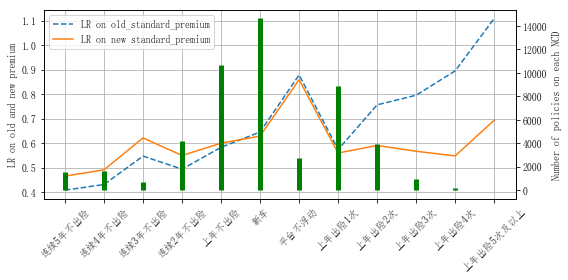

In [21]:
fig,ax1 = plt.subplots(figsize=(8,4))

ax1.set_ylabel('LR on old and new premium')
ax1.plot(NCD_desp,df_ncd_grp.LR_1,'--',label='LR on old_standard_premium')
ax1.plot(NCD_desp,df_ncd_grp.LR_2,label='LR on new standard_premium')
ax1.legend(loc='upper left')
ax1.grid()
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Number of policies on each NCD')
for ncd,ncd_desp in zip(df_ncd_grp.ncd_reason,NCD_desp):
    ax2.vlines(ncd_desp,0,df_ncd_grp[df_ncd_grp.ncd_reason==ncd].pol_no.values,'g',linewidth=5.0)
    #plt.ylim(0,20000)
plt.tight_layout()
if os.path.exists('Graphs/ncd.png'):
    os.remove('Graphs/ncd.png')
plt.savefig('Graphs/ncd.png',dpi=100,size=300)

In [22]:
def one_way(df,var):
    df_grp = df.groupby('%s'%var,as_index=False).agg({'pol_no':'count','clmno':'sum','ultloss':'sum','premium_ori':'sum','premium_new':'sum'})
    df_grp.loc[:,'%s_LR'%var] = df_grp.ultloss / df_grp.premium_new
    df_grp.loc[:,'%s_Freq'%var] = df_grp.clmno / df_grp.premium_new * 1000
    df_grp.loc[:,'%s_Sev'%var] = df_grp.ultloss / df_grp.clmno
    
    #print (df_grp)
    #df_grp.sort_values('%s'%var)
    plt.subplots(nrows=3,ncols=1,figsize=(8,8))
    
    items = ['LR','Freq','Sev']
    item_names = ['Loss ratio','Frequency','Severity']
    i = 1
    for item,names in zip(items,item_names):
        ax1 = plt.subplot(3,1,i)
        ax1.plot(df_grp['%s_%s'%(var,item)],label='%s'%names)
        plt.xticks(range(df_grp.shape[0]),df_grp['%s'%var],rotation=45)
        ax1.legend(loc='upper right')
        ax1.grid()
        ax2 = ax1.twinx()
        ax2.set_ylabel('Number of policies on %s'%var)
        for value in df_grp['%s'%var].astype(str):
            ax2.vlines(value,0,df_grp[df_grp['%s'%var].astype(str)==value].pol_no.values,'g',linewidth=5.0)
        i += 1
        plt.tight_layout()
    if os.path.exists('Graphs/%s.png'%var):
        os.remove('Graphs/%s.png'%var)
    plt.savefig('Graphs/%s.png'%var,dpi=100)

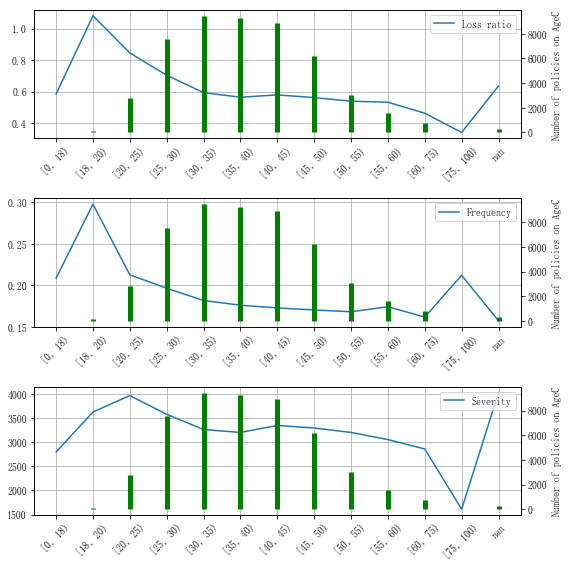

In [23]:
one_way(df_all,'AgeC')

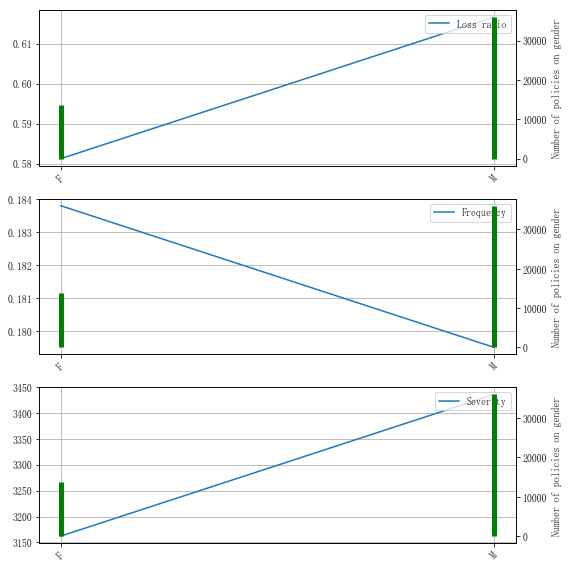

In [24]:
one_way(df_all,'gender')

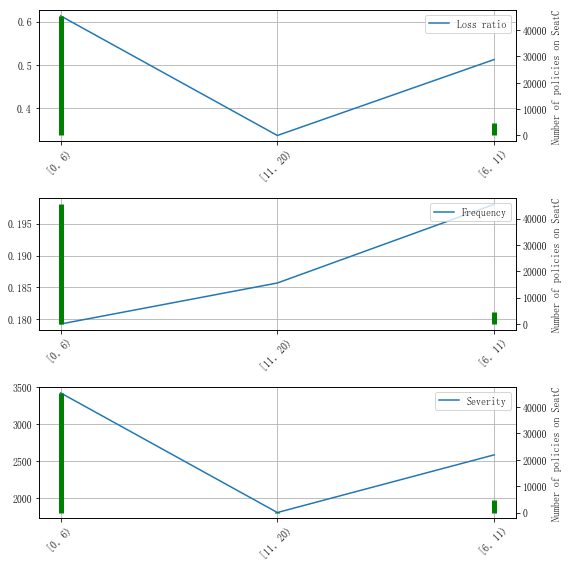

In [25]:
one_way(df_all,'SeatC')

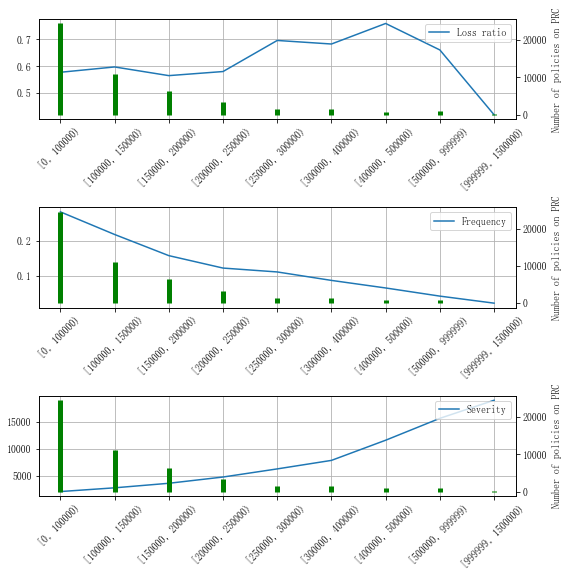

In [26]:
one_way(df_all,'PRC')

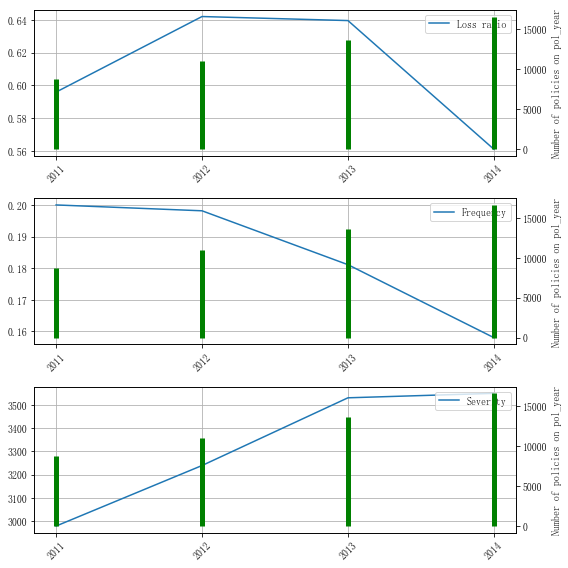

In [27]:
one_way(df_all,'pol_year')

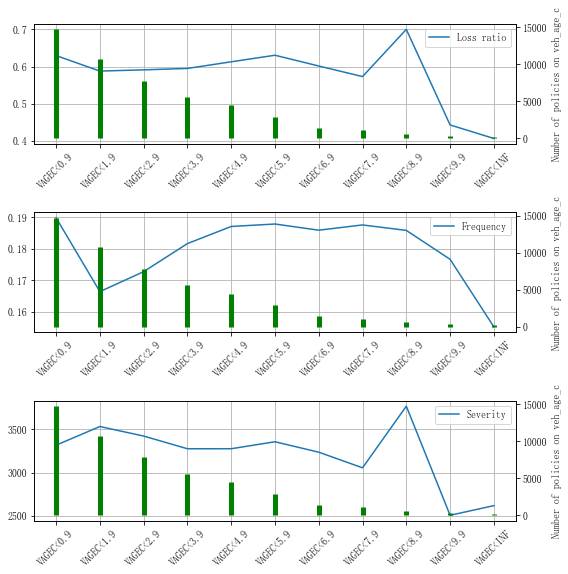

In [28]:
one_way(df_all,'veh_age_c')

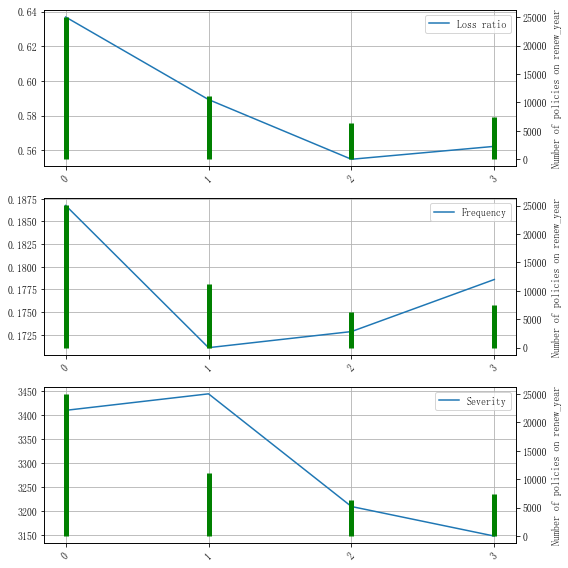

In [29]:
one_way(df_all,'renew_year')

#Two way analysis

In [30]:
#Two way analysis
def multi_dimension(df,var,split_var,label_var):
    df_grp = df.groupby(var,as_index=False).agg({'pol_no':'count','clmno':'sum','ultloss':'sum','premium_ori':'sum','premium_new':'sum'})
    df_grp.loc[:,'LR'] = df_grp.ultloss / df_grp.premium_new
    df_grp.loc[:,'Freq'] = df_grp.clmno / df_grp.premium_new * 1000
    df_grp.loc[:,'Sev'] = df_grp.ultloss / df_grp.clmno
        
    plt.subplots(nrows=3,ncols=1,figsize=(8,8))
    i = 1
    for target in ['LR','Freq','Sev']:
        ax = plt.subplot(3,1,i)
        #plt.xticks(range(df_grp['%s'%label_var].unique().shape[0]),df_grp['%s'%label_var].unique(),rotation=45)
        
        for var_value in df_grp['%s'%split_var].unique():
            df_tmp = df_grp[df_grp['%s'%split_var]==var_value]
            ax.plot(df_tmp['%s'%target],label='%s = %s'%(split_var,var_value))
            
        #print (df_grp['%s'%label_var].unique().shape[0])
        
        plt.title('%s'%target)
        i += 1
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
    if os.path.exists('Graphs/%s.png'%var):
        os.remove('Graphs/%s.png'%var)
    plt.savefig('Graphs/%s.png'%var)

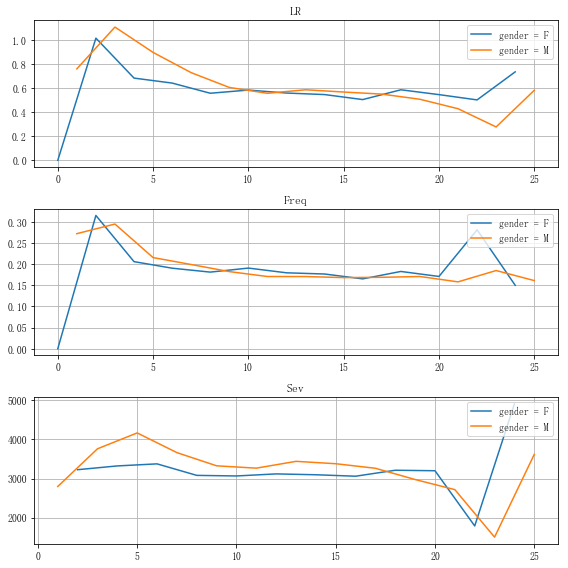

In [31]:
multi_dimension(df_all,['AgeC','gender'],'gender','AgeC')

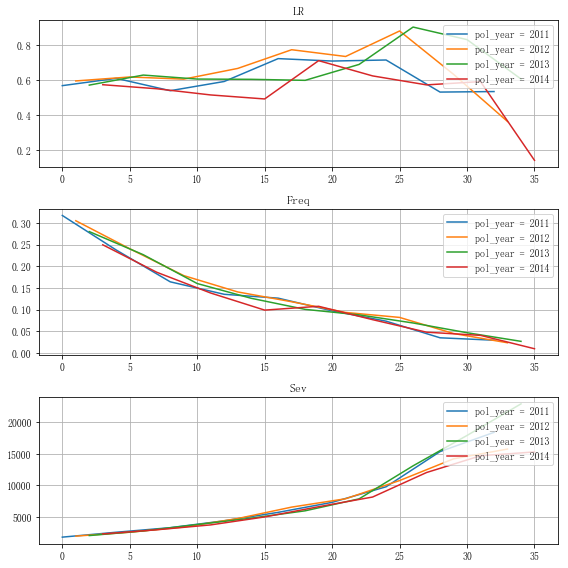

In [32]:
multi_dimension(df_all,['PRC','pol_year'],'pol_year','PRC')

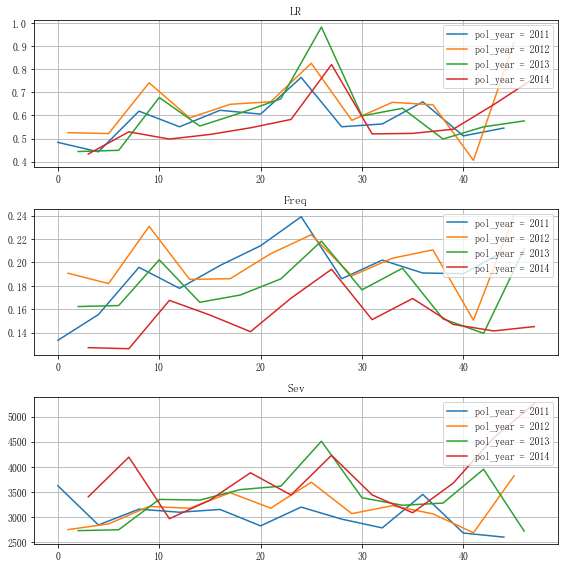

In [33]:
multi_dimension(df_all,['ncd_reason','pol_year'],'pol_year','ncd_reason')

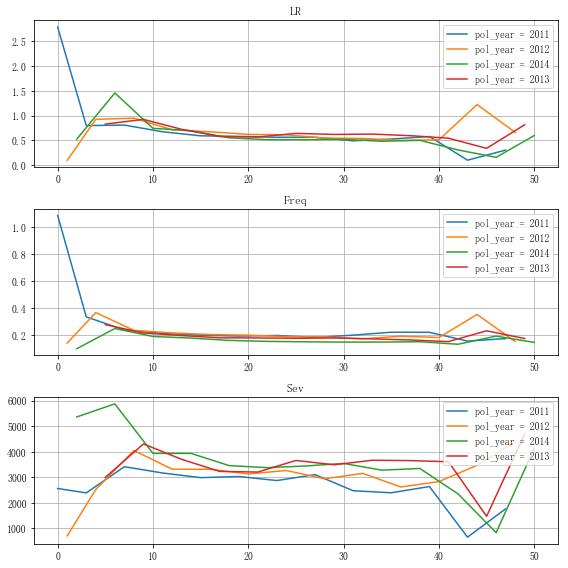

In [34]:
multi_dimension(df_all,['AgeC','pol_year'],'pol_year','AgeC')

#Distribution fit
#TBD

D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
D:\Anaconda\lib\site-packages\scipy\stats\_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


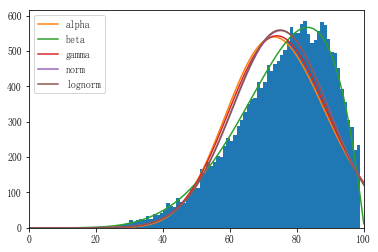

In [35]:
#Sample data
size = 20000
x = scipy.arange(size)
y = scipy.int_(scipy.round_(scipy.stats.beta.rvs(6,2,size=size)*100))
h = plt.hist(y,bins=range(100))

dict_names = ['alpha','beta','gamma','norm','lognorm']

for dist_name in dict_names:
    dist = getattr(scipy.stats,dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x,*param[:-2],loc=param[-2],scale=param[-1]) * size
    plt.plot(pdf_fitted,label=dist_name)
    plt.xlim(0,100)
plt.legend(loc='upper left')
plt.show()

D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


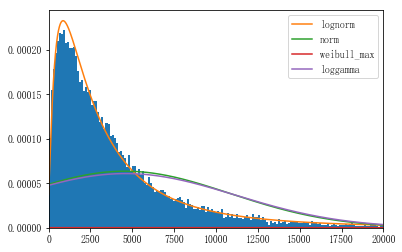

In [36]:
size = len(df_all[df_all.ultloss != 0].ultloss)
#print (size)
x = scipy.arange(size)
y = df_all[df_all.ultloss != 0].ultloss

h = plt.hist(y,bins=1000,density=True)

dict_names = ['lognorm','norm','weibull_max','loggamma']
for dist_name in dict_names:
    dist = getattr(scipy.stats,dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x,*param[:-2],loc=param[-2],scale=param[-1])
    plt.plot(pdf_fitted,label=dist_name)
    plt.xlim(0,20000)
    #plt.ylim(0,0.0005)
plt.legend(loc='upper right')
plt.show()

In [37]:
param

(1399.7376316806635, -1771736.0996195357, 245213.17130983993)

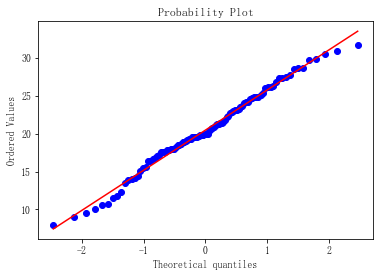

In [38]:
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

#Correlation

In [39]:
import seaborn as sns

In [40]:
columns = ['pol_year','insured_age','veh_price','veh_seat']
df_all[columns].corr()

,pol_year,insured_age,veh_price,veh_seat
pol_year,1.000000,-0.008797,0.001968,0.001057
insured_age,-0.008797,1.000000,0.004175,-0.002521
veh_price,0.001968,0.004175,1.000000,-0.135066
veh_seat,0.001057,-0.002521,-0.135066,1.000000


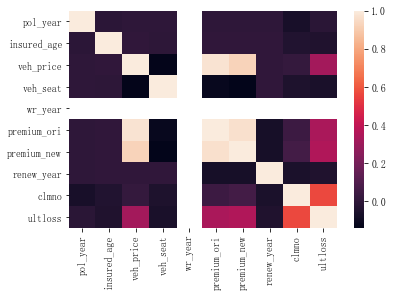

In [41]:
sns.heatmap(df_all.corr())

In [42]:
df_all.head()

,pol_no,usage_type,coverage,ncd_reason,pol_year,region,gender,insured_age,veh_age_c,veh_code,...,wr_year,nodc_ind,premium_ori,premium_new,renew_year,clmno,ultloss,AgeC,SeatC,PRC
0,2011OC00001,private,PD,0_F,2011,region_3,F,26.0,VAGEC<0.9,VTVZTNCX6669,...,1,Y,5640.0324,5543.598552,0,1,4509.826774,"[25, 30)","[0, 6)","[200000, 250000)"
1,2011OC00002,private,PD,0_E,2011,region_3,M,39.0,VAGEC<1.9,VMIUMCCW6668,...,1,Y,9654.3144,10738.602922,0,0,0.000000,"[35, 40)","[0, 6)","[500000, 999999)"
2,2011OA00003,private,PD,1,2011,region_1,M,39.0,VAGEC<4.9,VMLVYBCW6660,...,1,Y,6597.7800,7777.834560,2,1,2326.435493,"[35, 40)","[0, 6)","[300000, 400000)"
3,2011ON00004,private,PD,0_F,2011,region_14,M,35.0,VAGEC<0.9,VVNVRGCX6698,...,1,Y,19882.4880,19692.205320,0,1,20891.460269,"[35, 40)","[0, 6)","[500000, 999999)"
4,2011OA00005,private,PD,0_D,2011,region_1,M,45.0,VAGEC<4.9,VXZLEBCV6669,...,1,Y,3321.3288,2859.032526,3,0,0.000000,"[45, 50)","[0, 6)","[150000, 200000)"


In [43]:
df_all.columns

Index(['pol_no', 'usage_type', 'coverage', 'ncd_reason', 'pol_year', 'region',
       'gender', 'insured_age', 'veh_age_c', 'veh_code', 'import_ind',
       'veh_brand', 'veh_class', 'veh_series', 'veh_price', 'veh_seat',
       'wr_year', 'nodc_ind', 'premium_ori', 'premium_new', 'renew_year',
       'clmno', 'ultloss', 'AgeC', 'SeatC', 'PRC'],
      dtype='object')

In [44]:
from sklearn.preprocessing import LabelEncoder
columns=['ncd_reason','pol_year','region','veh_age_c','veh_code','import_ind','veh_brand','veh_class','veh_series',
        'renew_year','AgeC','SeatC','PRC','gender','ultloss']
df_all_cap = df_all[columns].copy()
le = LabelEncoder()
for col in df_all_cap.columns:
    df_all_cap['%s'%col] = le.fit_transform(df_all_cap['%s'%col].astype(str))

In [45]:
df_all_cap.corr()

,ncd_reason,pol_year,region,veh_age_c,veh_code,import_ind,veh_brand,veh_class,veh_series,renew_year,AgeC,SeatC,PRC,gender,ultloss
ncd_reason,1.000000,0.002174,0.001760,-0.120725,0.000026,-0.002693,-0.001027,0.001191,-0.000411,-0.139967,-0.003666,0.002210,-0.004412,-0.002418,0.102498
pol_year,0.002174,1.000000,-0.003416,-0.003790,-0.004518,-0.004626,0.007032,-0.002105,0.006581,0.001250,-0.007339,0.001028,0.003526,0.004458,-0.038799
region,0.001760,-0.003416,1.000000,0.003940,-0.008109,0.001213,0.007090,0.003130,0.007231,0.003512,0.003959,-0.003572,0.002575,0.005657,0.032459
veh_age_c,-0.120725,-0.003790,0.003940,1.000000,-0.000400,0.004616,0.004579,-0.000375,0.004005,0.606116,0.002136,0.000090,0.003800,0.003462,-0.038687
veh_code,0.000026,-0.004518,-0.008109,-0.000400,1.000000,0.178279,0.033240,-0.163339,0.024634,-0.003378,-0.002872,0.101439,-0.086914,0.010397,-0.013764
import_ind,-0.002693,-0.004626,0.001213,0.004616,0.178279,1.000000,-0.137469,-0.375927,-0.138043,0.004596,0.005398,0.291854,0.203937,0.001848,-0.030337
veh_brand,-0.001027,0.007032,0.007090,0.004579,0.033240,-0.137469,1.000000,0.134909,0.992160,0.002246,0.002315,-0.152494,0.185534,0.005113,0.023128
veh_class,0.001191,-0.002105,0.003130,-0.000375,-0.163339,-0.375927,0.134909,1.000000,0.121373,-0.003401,-0.000328,-0.773343,-0.066220,-0.003948,0.055296
veh_series,-0.000411,0.006581,0.007231,0.004005,0.024634,-0.138043,0.992160,0.121373,1.000000,0.002124,0.000909,-0.134925,0.166800,0.005450,0.022088
renew_year,-0.139967,0.001250,0.003512,0.606116,-0.003378,0.004596,0.002246,-0.003401,0.002124,1.000000,0.006672,0.005762,0.002794,-0.004732,-0.049520


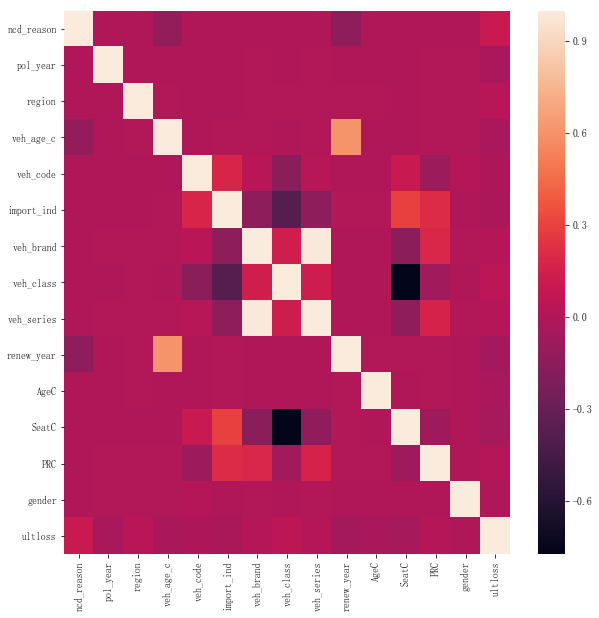

In [46]:
plt.subplots(ncols=1,nrows=1,figsize=(10,10))
sns.heatmap(df_all_cap.corr())
plt.savefig('Graphs/corr.png')

#从图中可以发现VAGEC和COUNTYEAR，及车龄和已续保年限存在一定的正相关，相关系数为0.6。


# 主成分分析

#建立车龄和续保年限的主成分分析，作为练习

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA()
pca.fit(df_all_cap[['veh_age_c','renew_year']])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [49]:
print ("特征向量部分",pca.components_)
print ("方差解释部分",pca.explained_variance_ratio_)

特征向量部分 [[ 0.93622249  0.35140781]
 [ 0.35140781 -0.93622249]]
方差解释部分 [0.87844639 0.12155361]


In [50]:
pca.transform(df_all_cap[['veh_age_c','renew_year']])

array([[-2.23857377,  0.14713136],
       [-1.30235128,  0.49853917],
       [ 2.20913181, -0.31968236],
       ...,
       [-2.23857377,  0.14713136],
       [-2.23857377,  0.14713136],
       [ 0.33668683, -1.02249799]])

#Explain how the numbers above has been transformed

In [51]:
df_all_cap[['veh_age_c','renew_year']][0:2]

,veh_age_c,renew_year
0,0,0
1,1,0


In [52]:
pca.mean_

array([2.0441, 0.9244])

In [53]:
pca.get_covariance()

array([[4.45004419, 1.41166219],
       [1.41166219, 1.21894902]])

In [54]:
print (0.9362*(0-2.0441) + 0.3514*(0 - 0.9244))
print (0.3514*(0-2.0441) + -0.9362*(0 - 0.9244))

-2.23852058
0.14712654000000014


In [55]:
#由于第一个PCA已经可以解释0.87的方差，因此最后保留第一个主成分即可。
pca.transform(df_all_cap[['veh_age_c','renew_year']])[:,0]

array([-2.23857377, -1.30235128,  2.20913181, ..., -2.23857377,
       -2.23857377,  0.33668683])

# 模型建立和验证

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
#import xgboost as xgb

In [57]:
df_all.isnull().sum()

pol_no           0
usage_type       0
coverage         0
ncd_reason       0
pol_year         0
region           0
gender         263
insured_age    272
veh_age_c        0
veh_code         0
import_ind       0
veh_brand        0
veh_class        0
veh_series       0
veh_price        0
veh_seat         0
wr_year          0
nodc_ind         0
premium_ori      0
premium_new      0
renew_year       0
clmno            0
ultloss          0
AgeC             0
SeatC            0
PRC              0
dtype: int64

In [58]:
df_all.gender.value_counts(dropna=False)

M      36023
F      13714
NaN      263
Name: gender, dtype: int64

In [59]:
df_all.AgeC.value_counts(dropna=False)

[30, 35)     9471
[35, 40)     9258
[40, 45)     8909
[25, 30)     7569
[45, 50)     6195
[50, 55)     3058
[20, 25)     2805
[55, 60)     1569
[60, 75)      759
nan           272
[18, 20)      114
[75, 100)      15
[0, 18)         6
Name: AgeC, dtype: int64

In [60]:
df_all.columns

Index(['pol_no', 'usage_type', 'coverage', 'ncd_reason', 'pol_year', 'region',
       'gender', 'insured_age', 'veh_age_c', 'veh_code', 'import_ind',
       'veh_brand', 'veh_class', 'veh_series', 'veh_price', 'veh_seat',
       'wr_year', 'nodc_ind', 'premium_ori', 'premium_new', 'renew_year',
       'clmno', 'ultloss', 'AgeC', 'SeatC', 'PRC'],
      dtype='object')

In [61]:
df_all_cap_clean = df_all_cap.drop(df_all_cap[(df_all_cap.AgeC==12)|((df_all_cap.gender==2))].index)
df_all_cap_clean.reset_index(inplace=True,drop=True)

df_all_clean = df_all.drop(df_all[(df_all.insured_age.isnull()==True)|((df_all.gender.isnull()==True))].index)
df_all_clean.reset_index(inplace=True,drop=True)

In [62]:
df_all_clean.shape,df_all.shape

((49465, 26), (50000, 26))

In [63]:
print ("There are %s policies removed in total"%(-df_all_clean.shape[0] + df_all.shape[0]))

There are 535 policies removed in total


In [64]:
y = df_all_cap_clean.ultloss
x = df_all_cap_clean.drop(['ultloss'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=20)

In [65]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((37098, 14), (37098,), (12367, 14), (12367,))

In [66]:
keep_columns = ['ncd_reason','region','veh_age_c', 'import_ind','veh_class', 'renew_year',  'AgeC', 'SeatC', 'PRC']

In [67]:
dt = DecisionTreeRegressor(min_samples_leaf=50)
dt.fit(x_train[keep_columns],y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [68]:
dt.score(x_test[keep_columns],y_test)

-0.0030130599797570934

# GLM

In [69]:
import statsmodels.api as sm

In [70]:
y = df_all_clean.ultloss
x = df_all_clean.drop('ultloss',axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=20)

In [71]:
def train_test(prop,df_all):
    #prop = 0.7
    np.random.seed(1234)#nominate the seed, so each time the random number won't change
    rand_index = np.random.randint(0,df_all.shape[0],size=int(prop*df_all.shape[0]))
    df_train = df_all.loc[rand_index,:]
    df_test = df_all.drop(df_train.index.values,axis=0)
    print (df_train.shape,df_test.shape)
    return df_train,df_test

In [72]:
def lift_curve(df_test,predicted,num_slice,target):
    
    df_test_val = pd.concat([df_test,predicted],axis=1)
    df_test_val.rename(columns={0:'pred'},inplace=True)

    df_test_val.loc[:,'pol_cnt'] = 1
    df_test_val.sort_values('pred',inplace=True)
    df_test_val.reset_index(inplace=True,drop=True)
    
    prop = round(1 / num_slice,2)
    cut_point = int(df_test_val.shape[0]*prop)
    increment = int(df_test_val.shape[0]*prop)
    score = np.zeros(df_test_val.shape[0])
    #base = cut_point
    i = 1
    for index,row in df_test_val.iterrows():
        #print (index,cut_point,i)
        if index < cut_point:
            pass
        else:
            cut_point += increment
            i += 1
        score[index] = min(i,num_slice)

    df_test_val.loc[:,'score'] = score
    return df_test_val.groupby('score',as_index=False).agg({'pred':['mean','sum'],'ultloss':['mean','sum'],'pol_cnt':'sum','premium_new':'mean','clmno':['sum','mean'],'%s'%target:['mean','sum']})

In [73]:
def output(model):
    #print (model)
    df_output = pd.DataFrame()
    df_output['variable'] = model.params.index
    df_output['coef'] = model.params.values
    df_output['std_err'] = model.bse.values
    df_output['pvalue'] = model.pvalues.values
    df_output['conf_int_lower'] = model.conf_int().values[:,0]
    df_output['conf_int_higer'] = model.conf_int().values[:,1]
    return df_output

In [74]:
def output_export(modelno,model,lift_curve):
    write_path = 'Results/%s_output.csv'%modelno
    with open(write_path, 'w',encoding='GB2312') as f:
        f.write(model.summary().as_csv())
    lift_curve.to_csv('Results/%s_lift_curve.csv'%modelno)

In [75]:
def draw_lift_curve(df_lift_curve,target):
    fig,ax1 = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    #plt.plot(df_lift_curve.score,df_lift_curve.pred)
    ax1 = plt.subplot(1,2,1)
    #ax1.plot(df_lift_curve.score,df_lift_curve.pred,color='b',label='Actual risk premium')
    ax1.plot(df_lift_curve.score,df_lift_curve['%s'%target]['mean'],color='b',label='Actual value')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Actual value')
    ax1.set_xlabel('Predicted value')
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.set_ylabel('Claim frequency')
    ax2.plot(df_lift_curve.score,df_lift_curve['clmno']['mean'],linestyle='--',color='r',label='Claim frequency')
    ax2.legend(loc='lower left')
    
    ax1 = plt.subplot(1,2,2)
    ax1.plot(df_lift_curve['pred']['mean'],df_lift_curve['%s'%target]['mean'],'ro',label='Actual vs Expected')
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes)
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Actual value')
    ax1.set_xlabel('Predicted value')
    ax1.grid()
    plt.tight_layout()

In [76]:
def deviance_plot(test,predicted):
    deviance = test.ultloss / predicted - 1
    plt.hist(deviance,bins=100)
    #return deviance

In [77]:
def model_fit(modelno,formula,dist,df_all,num_slice,target):
    #plt.subplots(nrows=2,ncols=1)
    #print (dist)
    train,test = train_test(0.7,df_all)
    dist_map = {'Tweedie':sm.families.Tweedie(var_power=1.7),'Poisson':sm.families.Poisson(),'Gamma':sm.families.Gamma(sm.families.links.log),'Gaussian':sm.families.Gaussian()}
    #model = sm.formula.glm(formula, family=sm.families.Tweedie(var_power=1.7), data=train).fit()
    model = sm.formula.glm(formula, family=dist_map[dist], data=train).fit()
    model_output = output(model)
    predicted = model.predict(exog=test)
    df_lift_curve = lift_curve(test,predicted,num_slice,target)
    output_export(modelno,model,df_lift_curve)
    #plt.subplot(2,1,1)
    draw_lift_curve(df_lift_curve,target)
    return model
    #plt.subplot(2,1,2)
    #deviance_plot(test,predicted)    

#Risk Premium Model

(34625, 26) (24464, 26)


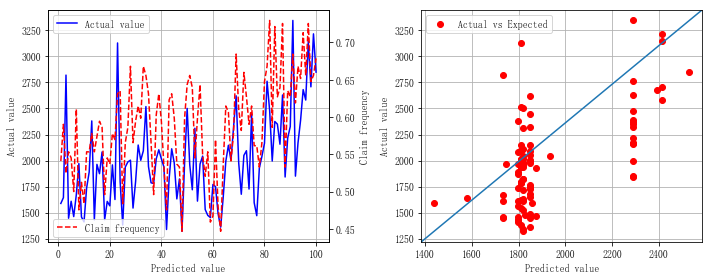

In [78]:
modelno = 10001
num_slice = 100
target = 'ultloss'
formula = "ultloss ~ C(AgeC,Treatment(reference='[30, 35)'))"
dist = 'Tweedie'
model_fit(modelno,formula,dist,df_all_clean,num_slice,target)

(34625, 26) (24464, 26)


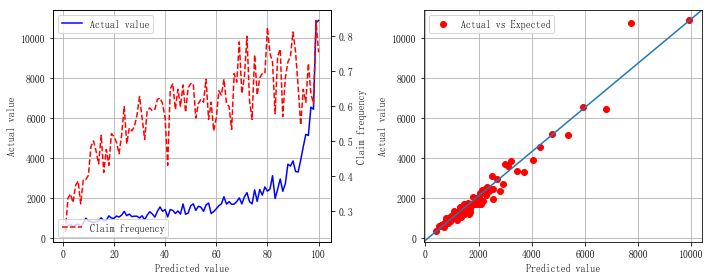

In [79]:
modelno = 10002
num_slice = 100
target = 'ultloss'
formula = "ultloss ~ C(ncd_reason, Treatment(reference='0_F')) + C(gender,Treatment(reference='F')) + C(AgeC,Treatment(reference='[30, 35)')) + C(SeatC,Treatment(reference='[0, 6)')) \
            + C(PRC,Treatment(reference='[0, 100000)')) + C(import_ind,Treatment(reference='合资'))"
dist = 'Tweedie'
model_fit(modelno,formula,dist,df_all_clean,num_slice,target)

In [80]:
df_all_clean2 = df_all_clean.copy()
#NCD
df_all_clean2.loc[df_all_clean2[(df_all_clean2.ncd_reason=='0_G')|(df_all_clean2.ncd_reason=='1')|(df_all_clean2.ncd_reason=='2')].index,'ncd_reason'] = '0~2'
#Age
df_all_clean2.loc[df_all_clean2[(df_all_clean2.AgeC=='[0, 18)')|(df_all_clean2.AgeC=='[18, 20)')].index,'AgeC'] = '[0, 20)'
df_all_clean2.loc[df_all_clean2[(df_all_clean2.AgeC=='[35, 40)')|(df_all_clean2.AgeC=='[40, 45)')|(df_all_clean2.AgeC=='[45, 50)')|(df_all_clean2.AgeC=='[50, 55)')|(df_all_clean2.AgeC=='[55, 60)')].index,'AgeC'] = '[35, 60)'
df_all_clean2.loc[df_all_clean2[(df_all_clean2.AgeC=='[75, 100)')|(df_all_clean2.AgeC=='[60, 75)')].index,'AgeC'] = '[60, 100)'
#Seat
df_all_clean2.loc[df_all_clean2[(df_all_clean2.SeatC=='[6, 11)')|(df_all_clean2.SeatC=='[11, 20)')].index,'SeatC'] = '[6, 20)'

(34625, 26) (24464, 26)


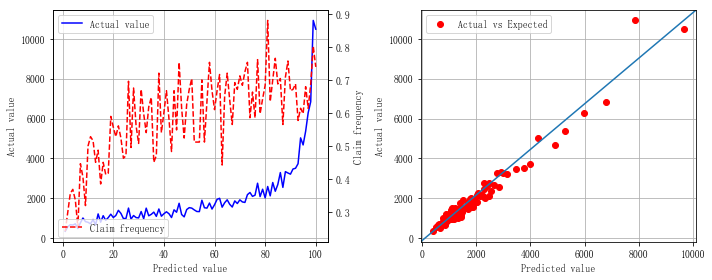

In [81]:
modelno = 10003
num_slice = 100
target = 'ultloss'
formula = "ultloss ~ C(ncd_reason, Treatment(reference='0_F')) + C(gender,Treatment(reference='F')) + C(AgeC,Treatment(reference='[30, 35)')) + C(SeatC,Treatment(reference='[0, 6)')) \
            + C(PRC,Treatment(reference='[0, 100000)')) + C(import_ind,Treatment(reference='合资'))"
dist = 'Tweedie'
model_fit(modelno,formula,dist,df_all_clean2,num_slice,target)

In [82]:
df_all_clean3 = df_all_clean2.copy()
#NCD
df_all_clean3.loc[df_all_clean3[(df_all_clean3.ncd_reason=='4')|(df_all_clean3.ncd_reason=='5=+')].index,'ncd_reason'] = '4 ~ 5+'
#Age
df_all_clean3.loc[df_all_clean3[(df_all_clean3.AgeC=='[35, 60)')|(df_all_clean3.AgeC=='[30, 35)')].index,'AgeC'] = '[30, 60)'
#Purchase price
df_all_clean3.loc[df_all_clean3[(df_all_clean3.PRC=='[500000, 999999)')|(df_all_clean3.PRC=='[999999, 1500000)')].index,'PRC'] = '[500000, 1500000)'

(34625, 26) (24464, 26)


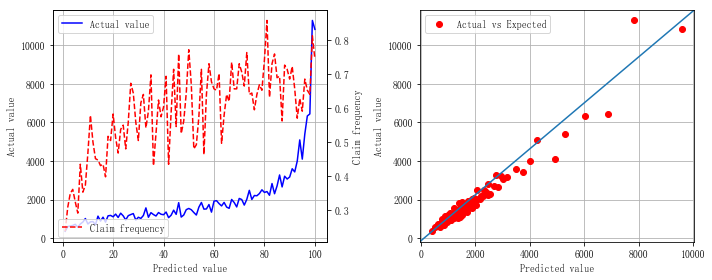

In [83]:
modelno = 10004
num_slice = 100
target = 'ultloss'
formula = "ultloss ~ C(ncd_reason, Treatment(reference='0_F')) + C(gender,Treatment(reference='F')) + C(AgeC,Treatment(reference='[30, 60)')) + C(SeatC,Treatment(reference='[0, 6)')) \
            + C(PRC,Treatment(reference='[0, 100000)')) + C(import_ind,Treatment(reference='合资'))"
dist = 'Tweedie'
model_fit(modelno,formula,dist,df_all_clean3,num_slice,target)

In [84]:
df_all_clean4 = df_all_clean3.copy()
#Purchase price
df_all_clean4.loc[df_all_clean4[(df_all_clean4.PRC=='[400000, 500000)')|(df_all_clean4.PRC=='[500000, 1500000)')].index,'PRC'] = '[400000, 1500000)'

In [85]:
df_all_clean3.PRC.value_counts(dropna=False).sort_index()

[0, 100000)          24221
[100000, 150000)     10904
[150000, 200000)      6305
[200000, 250000)      3253
[250000, 300000)      1484
[300000, 400000)      1488
[400000, 500000)       808
[500000, 1500000)     1002
Name: PRC, dtype: int64

(34625, 26) (24464, 26)


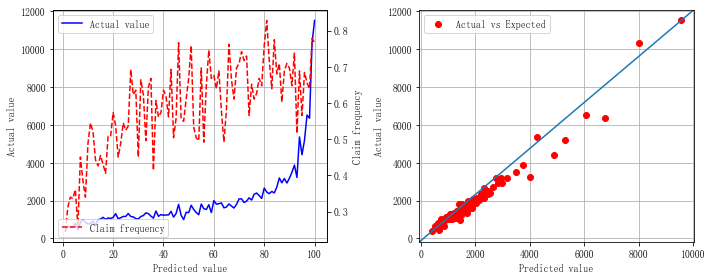

In [86]:
modelno = 10005
num_slice = 100
target = 'ultloss'
formula = "ultloss ~ C(ncd_reason, Treatment(reference='0_F')) + C(gender,Treatment(reference='F')) + C(AgeC,Treatment(reference='[30, 60)')) + C(SeatC,Treatment(reference='[0, 6)')) \
            + C(PRC,Treatment(reference='[0, 100000)')) + C(import_ind,Treatment(reference='合资'))"
dist = 'Tweedie'
model_10005 = model_fit(modelno,formula,dist,df_all_clean4,num_slice,target)

In [87]:
prop = 0.7
train_pp,test_pp = train_test(prop,df_all_clean4)
pred_pp = model_10005.predict(test_pp)

(34625, 26) (24464, 26)


#Frequency model

(34625, 26) (24464, 26)


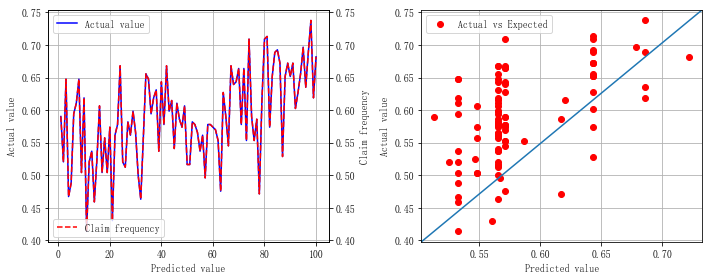

In [88]:
modelno = 20001
num_slice = 100
target = 'clmno'
formula = "clmno ~ C(AgeC,Treatment(reference='[30, 35)'))"
dist = 'Poisson'
model_fit(modelno,formula,dist,df_all_clean,num_slice,target)

(34625, 26) (24464, 26)


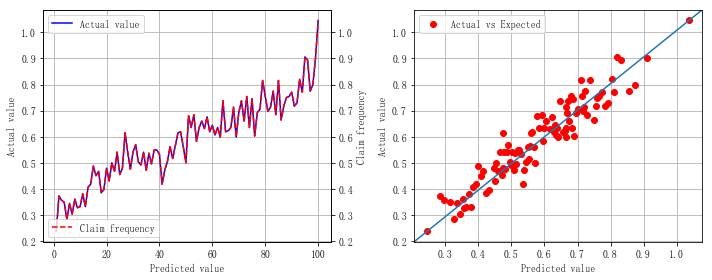

In [89]:
modelno = 20002
num_slice = 100
target = 'clmno'
formula = "clmno ~ C(ncd_reason, Treatment(reference='0_F')) + C(gender,Treatment(reference='F')) + C(AgeC,Treatment(reference='[30, 35)')) + C(SeatC,Treatment(reference='[0, 6)')) \
            + C(PRC,Treatment(reference='[0, 100000)')) + C(import_ind,Treatment(reference='合资'))"
dist = 'Poisson'
model_20002 = model_fit(modelno,formula,dist,df_all_clean,num_slice,target)

In [90]:
prop = 0.7
train_freq,test_freq = train_test(prop,df_all_clean)
pred_freq = model_20002.predict(test_freq)

(34625, 26) (24464, 26)


#Severity Model

In [91]:
df_all_clean_sev = df_all_clean[df_all_clean['clmno']!=0]
df_all_clean_sev.loc[:,'avg_clm_amt'] = df_all_clean_sev.loc[:,'ultloss'] / df_all_clean_sev.loc[:,'clmno']
df_all_clean_sev.reset_index(inplace=True,drop=True)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [92]:
df_all_clean_sev.head()

,pol_no,usage_type,coverage,ncd_reason,pol_year,region,gender,insured_age,veh_age_c,veh_code,...,nodc_ind,premium_ori,premium_new,renew_year,clmno,ultloss,AgeC,SeatC,PRC,avg_clm_amt
0,2011OC00001,private,PD,0_F,2011,region_3,F,26.0,VAGEC<0.9,VTVZTNCX6669,...,Y,5640.0324,5543.598552,0,1,4509.826774,"[25, 30)","[0, 6)","[200000, 250000)",4509.826774
1,2011OA00003,private,PD,1,2011,region_1,M,39.0,VAGEC<4.9,VMLVYBCW6660,...,Y,6597.7800,7777.834560,2,1,2326.435493,"[35, 40)","[0, 6)","[300000, 400000)",2326.435493
2,2011ON00004,private,PD,0_F,2011,region_14,M,35.0,VAGEC<0.9,VVNVRGCX6698,...,Y,19882.4880,19692.205320,0,1,20891.460269,"[35, 40)","[0, 6)","[500000, 999999)",20891.460269
3,2011OA00006,private,PD,1,2011,region_1,M,49.0,VAGEC<6.9,VIZLIMCW6661,...,Y,2723.0436,2684.756328,2,3,2593.606966,"[45, 50)","[0, 6)","[0, 100000)",864.535655
4,2011OJ00007,private,PD,2,2011,region_10,F,49.0,VAGEC<4.9,VWUUNYCV6668,...,Y,4182.0624,5565.406968,1,1,682.194727,"[45, 50)","[0, 6)","[150000, 200000)",682.194727


(14912, 27) (10566, 27)


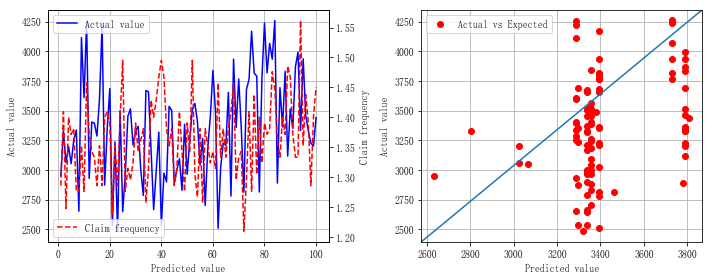

In [93]:
modelno = 30001
target = 'avg_clm_amt'
formula = "avg_clm_amt ~ C(AgeC,Treatment(reference='[30, 35)'))"
dist = 'Gamma'
num_slice = 100
model_fit(modelno,formula,dist,df_all_clean_sev,num_slice,target)

(14912, 27) (10566, 27)


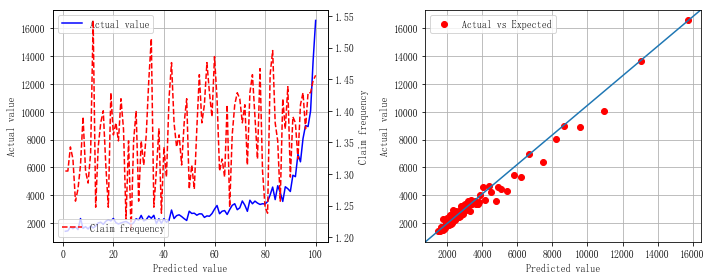

In [94]:
modelno = 30002
num_slice = 100
target = 'avg_clm_amt'
formula = "avg_clm_amt ~ C(ncd_reason, Treatment(reference='0_F')) + C(gender,Treatment(reference='F')) + C(AgeC,Treatment(reference='[30, 35)')) + C(SeatC,Treatment(reference='[0, 6)')) \
            + C(PRC,Treatment(reference='[0, 100000)')) + C(import_ind,Treatment(reference='合资'))"
dist = 'Gamma'
model_30002 = model_fit(modelno,formula,dist,df_all_clean_sev,num_slice,target)

In [95]:
prop = 0.7
train_sev,test_sev = train_test(prop,df_all_clean)
pred_sev = model_30002.predict(test_sev)

(34625, 26) (24464, 26)


#XGBOOST

In [96]:
df_all_clean4.head()

,pol_no,usage_type,coverage,ncd_reason,pol_year,region,gender,insured_age,veh_age_c,veh_code,...,wr_year,nodc_ind,premium_ori,premium_new,renew_year,clmno,ultloss,AgeC,SeatC,PRC
0,2011OC00001,private,PD,0_F,2011,region_3,F,26.0,VAGEC<0.9,VTVZTNCX6669,...,1,Y,5640.0324,5543.598552,0,1,4509.826774,"[25, 30)","[0, 6)","[200000, 250000)"
1,2011OC00002,private,PD,0_E,2011,region_3,M,39.0,VAGEC<1.9,VMIUMCCW6668,...,1,Y,9654.3144,10738.602922,0,0,0.000000,"[30, 60)","[0, 6)","[400000, 1500000)"
2,2011OA00003,private,PD,0~2,2011,region_1,M,39.0,VAGEC<4.9,VMLVYBCW6660,...,1,Y,6597.7800,7777.834560,2,1,2326.435493,"[30, 60)","[0, 6)","[300000, 400000)"
3,2011ON00004,private,PD,0_F,2011,region_14,M,35.0,VAGEC<0.9,VVNVRGCX6698,...,1,Y,19882.4880,19692.205320,0,1,20891.460269,"[30, 60)","[0, 6)","[400000, 1500000)"
4,2011OA00005,private,PD,0_D,2011,region_1,M,45.0,VAGEC<4.9,VXZLEBCV6669,...,1,Y,3321.3288,2859.032526,3,0,0.000000,"[30, 60)","[0, 6)","[150000, 200000)"


#Modeling comparison

In [97]:
df_all_models = pd.DataFrame()
df_all_models['pure_prem'] = pred_pp
df_all_models['freq'] = pred_freq
df_all_models['sev'] = pred_sev
df_all_models['pure_prem_cmb'] = df_all_models['freq'] * df_all_models['sev']
df_all_models['actual_loss'] = df_all_clean['ultloss']
#df_all_models['pure_prem_xgb'] = test_xgb['pred']

In [98]:
df_all_models.corr()

,pure_prem,freq,sev,pure_prem_cmb,actual_loss
pure_prem,1.000000,0.359311,0.907207,0.978746,0.357446
freq,0.359311,1.000000,0.048525,0.385070,0.116808
sev,0.907207,0.048525,1.000000,0.901888,0.338961
pure_prem_cmb,0.978746,0.385070,0.901888,1.000000,0.357193
actual_loss,0.357446,0.116808,0.338961,0.357193,1.000000


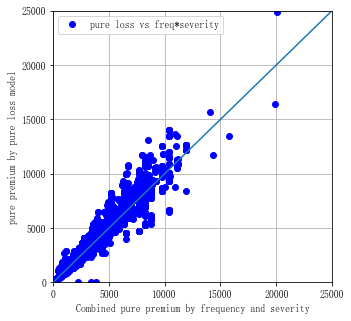

In [99]:
fig,ax1 = plt.subplots(figsize=(5,5))
ax1 = plt.subplot(1,1,1)
ax1.plot(df_all_models['pure_prem'],df_all_models['pure_prem_cmb'],'bo',label='pure loss vs freq*severity')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes)
ax1.legend(loc='upper left')
ax1.set_ylabel('pure premium by pure loss model')
ax1.set_xlabel('Combined pure premium by frequency and severity')
ax1.set_xlim(0,25000)
ax1.set_ylim(0,25000)
ax1.grid()

In [100]:
df_all_models['ratio'] = df_all_models['pure_prem_cmb'] / df_all_models['pure_prem']
df_all_models.loc[:,'pol_cnt'] = 1
df_all_models.sort_values('ratio',inplace=True)
df_all_models.reset_index(inplace=True,drop=True)

num_slice = 10
prop = round(1/num_slice,2)
cut_point = int(df_all_models.shape[0]*prop)
increment = int(df_all_models.shape[0]*prop)
score = np.zeros(df_all_models.shape[0])

i = 1
for index,row in df_all_models.iterrows():
    #print (index,cut_point,i)
    if index < cut_point:
        pass
    else:
        cut_point += increment
        i += 1
    score[index] = min(i,num_slice)

df_all_models.loc[:,'score'] = score
df_all_models_grp = df_all_models.groupby('score',as_index=False).agg({'pure_prem':'mean','pure_prem_cmb':'mean','pol_cnt':'sum','actual_loss':'mean'})

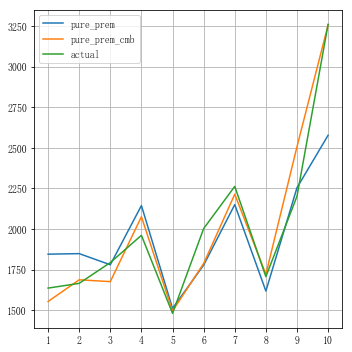

In [101]:
fig,ax = plt.subplots(figsize=(5,5))
ax = plt.subplot(1,1,1)
ax.plot(df_all_models_grp['score'],df_all_models_grp['pure_prem'],label='pure_prem')
ax.plot(df_all_models_grp['score'],df_all_models_grp['pure_prem_cmb'],label='pure_prem_cmb')
ax.plot(df_all_models_grp['score'],df_all_models_grp['actual_loss'],label='actual')
ax.set_xticks([i for i in range(1,11)])
ax.legend(loc='upper left')
ax.grid()
plt.tight_layout()

# 模型自由练习部分，添加自己认为有用的变量进行测试

#Decision Tree

In [102]:
df_all_clean4.head()

,pol_no,usage_type,coverage,ncd_reason,pol_year,region,gender,insured_age,veh_age_c,veh_code,...,wr_year,nodc_ind,premium_ori,premium_new,renew_year,clmno,ultloss,AgeC,SeatC,PRC
0,2011OC00001,private,PD,0_F,2011,region_3,F,26.0,VAGEC<0.9,VTVZTNCX6669,...,1,Y,5640.0324,5543.598552,0,1,4509.826774,"[25, 30)","[0, 6)","[200000, 250000)"
1,2011OC00002,private,PD,0_E,2011,region_3,M,39.0,VAGEC<1.9,VMIUMCCW6668,...,1,Y,9654.3144,10738.602922,0,0,0.000000,"[30, 60)","[0, 6)","[400000, 1500000)"
2,2011OA00003,private,PD,0~2,2011,region_1,M,39.0,VAGEC<4.9,VMLVYBCW6660,...,1,Y,6597.7800,7777.834560,2,1,2326.435493,"[30, 60)","[0, 6)","[300000, 400000)"
3,2011ON00004,private,PD,0_F,2011,region_14,M,35.0,VAGEC<0.9,VVNVRGCX6698,...,1,Y,19882.4880,19692.205320,0,1,20891.460269,"[30, 60)","[0, 6)","[400000, 1500000)"
4,2011OA00005,private,PD,0_D,2011,region_1,M,45.0,VAGEC<4.9,VXZLEBCV6669,...,1,Y,3321.3288,2859.032526,3,0,0.000000,"[30, 60)","[0, 6)","[150000, 200000)"


In [103]:
#prop = 0.7
#train_pp,test_pp = train_test(prop,df_all_clean4)
#pred_pp = model_10005.predict(test_pp)
df_all_clean4_dt = df_all_clean4[['ncd_reason','gender','AgeC','SeatC','PRC','import_ind']]
pred_pp_all = model_10005.predict(df_all_clean4)
df_all_clean4_dt.loc[:,'pred_pp_all'] = pred_pp_all

columns = ['ncd_reason','gender','AgeC','SeatC','PRC','import_ind']
for col in columns:
    df_all_clean4_dt.loc[:,'%s'%col] = le.fit_transform(df_all_clean4_dt['%s'%col])

x_train,y_train = df_all_clean4_dt.drop('pred_pp_all',axis=1),df_all_clean4_dt['pred_pp_all']

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [104]:
df_all_clean4_dt.head()

,ncd_reason,gender,AgeC,SeatC,PRC,import_ind,pred_pp_all
0,5,0,2,0,3,2,4567.558964
1,4,1,3,0,6,2,6527.580315
2,6,1,3,0,5,2,6755.719963
3,5,1,3,0,6,2,8784.752685
4,3,1,3,0,2,0,1309.879208


In [105]:
df_all_clean4_dt.shape,x_train.shape,y_train.shape

((49465, 7), (49465, 6), (49465,))

In [106]:
from sklearn.tree import DecisionTreeRegressor

In [107]:
dt = DecisionTreeRegressor(max_depth=3,random_state=20)
dt.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=20, splitter='best')

In [108]:
dt.feature_importances_

array([0.10459485, 0.        , 0.        , 0.        , 0.89540515,
       0.        ])

In [109]:
from sklearn.externals.six import StringIO
import pydotplus
from sklearn import tree

In [111]:
feature_name = ['ncd_reason','gender','AgeC','SeatC','PRC','import_ind']
target_name = 'ultloss'
dot_data = StringIO()
tree.export_graphviz(dt,out_file = dot_data,feature_names=feature_name,
                     class_names=target_name,filled=True,rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_pdf("Decision_tree.pdf")
graph.write_png("Decision_tree.png")

print('Visible tree plot saved as png.')

Visible tree plot saved as png.
